In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import h5py
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


### Read data

In [2]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
path = '/'.join(temp)

with h5py.File(path + '/data/train_16frames.h5', 'r') as h5file:
    X_train = h5file['train'][:]
    Y_train = h5file['target'][:]
    h5file.close()

# shuffle both
X_train, Y_train = shuffle(X_train, Y_train)
    
X_train.shape, Y_train.shape

((3596, 16, 13), (3596, 4))

### Split to train and test sets

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=15)

### Build a LSTM classifier

In [4]:
np.random.seed(14)  # fix the random numbers generator state

batch_size = 16
hidden_units = 10
input_shape = X_train.shape[1:]
nb_epochs = 40
nb_classes = Y_train.shape[1]
dropout = 0.05
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=1)
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model = Sequential()
model.add(LSTM(units=hidden_units, kernel_initializer='uniform', recurrent_initializer='uniform', 
               dropout=dropout, use_bias=True, unit_forget_bias=True, activation='tanh', recurrent_activation='sigmoid', 
               input_shape=input_shape))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

model.summary()
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, callbacks=[early_stopping],
                    validation_split=0.15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 1,004
Trainable params: 1,004
Non-trainable params: 0
_________________________________________________________________
Train on 2750 samples, validate on 486 samples
Epoch 1/40
2750/2750 [==============================] - 9s 3ms/step - loss: 1.3309 - categorical_accuracy: 0.3793 - val_loss: 1.2911 - val_categorical_accuracy: 0.3971
Epoch 2/40
2750/2750 [==============================] - 4s 1ms/step - loss: 1.2595 - categorical_accuracy: 0.4240 - val_loss: 1.2641 - val_categorical_accuracy: 0.4177
Epoch 3/40
2750/2750 

### Evaluate the model performance

In [5]:
Y_pred = model.predict_proba(X_test)

ref = np.zeros(shape=(Y_test.shape[0], Y_test.shape[1]))
i = 0
for idx in Y_pred.argmax(axis=-1):
    ref[i, idx] = 1 
    i += 1
    
print('Accuracy is', accuracy_score(Y_test, ref))
AUC = roc_auc_score(Y_test, Y_pred)
print('AUC is', AUC)

Accuracy is 0.5027777777777778
AUC is 0.7691542847923984


In [6]:
Y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [7]:
Y_pred

array([[0.5577736 , 0.41222003, 0.01161036, 0.01839604],
       [0.27310646, 0.0820628 , 0.41377753, 0.23105322],
       [0.83173543, 0.05229939, 0.02338157, 0.09258366],
       ...,
       [0.01640676, 0.01346094, 0.03931861, 0.9308137 ],
       [0.8251634 , 0.11693434, 0.02074148, 0.03716078],
       [0.68323004, 0.2838404 , 0.01262672, 0.0203029 ]], dtype=float32)

### Visualize training

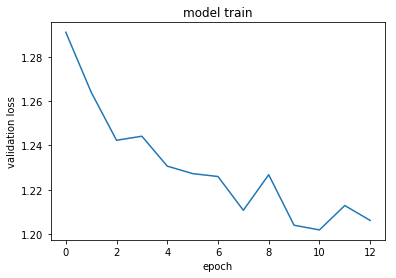

In [8]:
plt.plot(history.history['val_loss'])
plt.title('model train')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.show()

### Save model weights

In [12]:
model.save(path + '/data/model_LSTM.h5')